# Imports & Constants

In [41]:
from __future__ import division
import numpy as np
import sympy
sympy.init_printing()
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact
from scipy.integrate import odeint
from scipy.optimize import fsolve

In [42]:
g = 9.807

# Control valve characteristics

In [43]:
CV_size = 110.08
# in mm
C_cv = 124
# single port Ccv values

# Fluid Properties

In [44]:
ρ = 1000 #kg/m^3
SG = ρ/1000
μ = 8.9E-4 #Pa.s

# Pipeline Properties

In [45]:
d = 110.08 #in mm
d_inch = d * 0.03937 #in inches
D = d/1000 #in m
Length = 16 #in m
epsilon = 0.015 #in mm
dZ = 0 #change in elevation in m
Pi = 0 #pressure at reference point at start of MEB in kPa
Pf = 0 #pressure at reference point at end of MEB in kPa
ui = 0 #linear flow rate at reference point at start of MEB in m/s
uf = 0 #linear flow rate at reference point at end of MEB in m/s
resistances = [12, 0, 0, 8, 8, 0, 1, 1]
# (90 deg elbows, Large radius elbow, Butterfly valves, Gate&Ball Valves, soft tee, hard tee, 
# Pipe enterances, Pipe exits)
W_nom = 30000/60/60 #kg/s

In [46]:
reducer_θ = 30
enlarger_θ = 30
if CV_size < d:
    β = CV_size/d
    CV_smaller = True
elif CV_size > d:
    β = d/CV_size
    CV_smaller = False
else:
    CV_smaller = True 
    β = 1
# if the valve is the same size as the line β = 1 and the K equations become 0

if CV_smaller == True:
    # if the control valve is smaller than the normal line the K values must be adjusted for the larger line since formula are
    # given in terms of the flow in the smaller line
    if reducer_θ < 45:
        reducer_K = 0.81*np.sin(reducer_θ/2)*(1-β**2) * β**4
    else:
        reducer_K = 0.5 (1-β**2)*(np.sin(reducer_θ/2))**0.5 * β**4
    if enlarger_θ < 45:
        enlarger_K = 2.61*np.sin(enlarger_θ/2)*(1-β**2) * β**4
    else:
        enlarger_K = (1-β**2)**2 * β**4
elif CV_smaller == False:
    if reducer_θ < 45:
        reducer_K = 0.81*np.sin(reducer_θ/2)*(1-β**2)
    else:
        reducer_K = 0.5 (1-β**2)*(np.sin(reducer_θ/2))**0.5
    if enlarger_θ < 45:
        enlarger_K = 2.61*np.sin(enlarger_θ/2)*(1-β**2)
    else:
        enlarger_K = (1-β**2)**2

# Functions 

In [47]:
def reynolds(u):
    Re = (D * u * ρ) / μ
    return Re

def dPelevation(dh):
    dPel = ρ * g * dh / 1000
    return dPel

def dPeq_f(W):
    dPeqr = 26.67
    Wr = 30000/60/60
    dPeq = dPeqr * (W/Wr)**2
    return dPeq

def dP_friction(Lp, u, resistances):
    # Resistances should be given as
    # (90 deg elbows, large radius elbow, Butterfly valves, Gate&Ball Valves, soft tee, hard tee,
    # Pipe enterances, Pipe exits)
    # Valves are taken as fully open
    # All connections are taken as flanged
    K1 = [800, 800, 800, 300, 150, 800, 160, 0]
    Kinf = [0.25, 0.2, 0.25, 0.1, 0.5, 0.8, 0.5, 1]
    # Initial Guess for f_prime
    sqrt_f_prime = 0.1414
    Re = reynolds(u)
    # Iterate to find f_prime using colebrook
    difference = 1
    while abs(difference) > 1E-5:
        sqrt_f_prime = 1/(-2 * np.log10(epsilon/D/3.7 + 2.51/(Re*sqrt_f_prime)))
        difference = 1/(sqrt_f_prime) - (-2 * np.log10(epsilon/D/3.7 + 2.51/(Re*sqrt_f_prime)))
    f_prime = sqrt_f_prime**2
    # Calculate the resistance coefficient for resistances
    Ktot = 0
    for i in range(0, 8, 1):
        if i < 6:
            K = K1[i]/Re + Kinf[i]*(1 + 1/d_inch)
            Ktot += K
        else:
            K = K1[i]/Re + Kinf[i]
            Ktot += K
    # Add resistance for the enlarger & reducer
    Ktot += enlarger_K
    Ktot += reducer_K
    # Add Resistance for the pipe
    K_pipe = f_prime*Lp/D
    Ktot += K_pipe
    # Calculate friction loss
    dP_friction = Ktot*(ρ*u**2/2000)
    return dP_friction

def system(W):
    # Mass flow rate in kg/s
    u = (W/ρ) / ((np.pi*D**2)/4)
    dPel = dPelevation(dZ)
    dPep = Pf - Pi
    dPke = 1*ρ/2000*(uf**2 - ui**2)
    dPf = dP_friction(Length, u, resistances) #Excludes control valve
    dPeq = dPeq_f(W)
    dP_system = dPel + dPep + dPke + dPf + dPeq
    return dP_system

def sub_total_variable(W):
    # Mass flow rate in kg/s
    u = (W/ρ) / ((np.pi*D**2)/4)
    dPke = 1*ρ/2000*(uf**2 - ui**2)
    dPf = dP_friction(Length, u, resistances) #Excludes control valve
    dPeq = dPeq_f(W)
    dP_stv = dPke + dPf + dPeq
    return dP_stv

# Plot System curve and Pump curve for selection of control valve trim

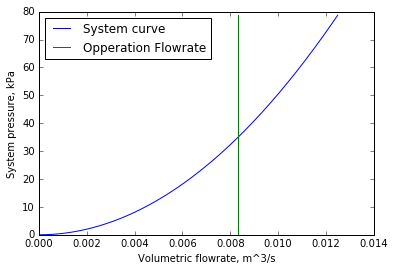

In [48]:
Wrange = np.arange(0.01, W_nom*1.5, 0.01)
Prange = []
for i in Wrange:
    P = system(i)
    Prange.append(P)
    
Qrange = Wrange/ρ
plt.plot(Qrange, Prange, label ='System curve')
Q_nom = W_nom/ρ
plt.plot([Q_nom, Q_nom], [0, Prange[-1]], label='Opperation Flowrate')

plt.legend(loc=0)
plt.xlabel('Volumetric flowrate, m^3/s')
plt.ylabel('System pressure, kPa')

# Control valve calculations

In [49]:
W_n = W_nom #kg/s
W_d = 1.15*W_n #kg/s
W_m = 1.15/1.05 * W_n #kg/s

V_gal_n = W_n/ρ*264.172*60 #gal/min
V_gal_d = W_d/ρ*264.172*60 #gal/min
V_gal_m = W_m/ρ*264.172*60 #gal/min

dP_cvd = (V_gal_d/(C_cv*1))**2 * SG * 6.89476 #kPA
dP_stvn = sub_total_variable(W_n)
dP_stvd = dP_stvn * (W_d/W_n)**2

if dP_cvd >= 0.25*dP_stvd and dP_cvd <= 0.5*dP_stvd:
    print ("Rule 2(d) met")
else:
    print ("Rule 2(d) failed")
print (0.25*dP_stvd, '<', dP_cvd, '<', 0.5*dP_stvd)

dP_ad = system(W_d) + dP_cvd
dP_an = dP_ad

dP_cvn = dP_an - system(W_n)

if dP_cvn >= 0.5*dP_stvn and dP_cvn <= 1.5*dP_stvn:
    print("Rule 2(n) met")
else:
    print("Rule 2(n) failed")
print (0.5*dP_stvn, '<', dP_cvn, '<', 1.5*dP_stvn)
    
fx_n = V_gal_n/(C_cv*(dP_cvn*0.145038/SG)**0.5)

if fx_n >= 0.1:
    print("Rule 1(n) met")
else:
    print("Rule 1(n) failed")
print (fx_n, '>', 0.1)

Rule 2(d) failed
11.58259979 < 10.346299375718388 < 23.1651995801
Rule 2(n) met
17.5162189641 < 21.6406598794 < 52.5486568924
Rule 1(n) met
0.601255348148 > 0.1
